# Gym-QuantCircuit Tutorial

A step by step example of using the custom quantum circuit gym environment to create and visualise quantum circuits.

In [1]:
import gym
import gym_quantcircuit
import numpy as np

### Creating a new environment

The make method creates a completely blank environment that has no functionality yet.

In [2]:
env = gym.make('quantcircuit-v0')

The environment has an extra initialisation method that allows it to take in arguments that help with customisation. These arguments include the number of desired qubits in the circuit, whether calculations are to be performed with unitary matrices or statevectors, the set of gates used, the physical connectivity of the qubits, and the goal statevector or unitary.

In [3]:
num_qubits = 3
test_goal_state = [0j] * (2**num_qubits - 1) + [1+0j]

In [4]:
env.var_init(num_qubits,
             unitary=False,
             gate_group='pauli',
             connectivity='fully_connected',
             goal_state=test_goal_state)

The above line initialises the environment with a blank circuit with three qubits, using statevectors, using the pauli gate group, with a fully-connected physical architecture, and with a goal statevector of each qubit being flipped. This can be visualised with the following code.

In [5]:
env.render()

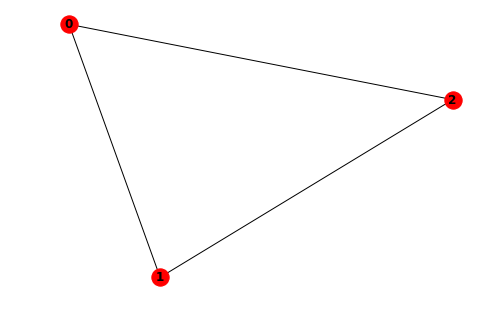

In [6]:
env.plot_connectivity_graph()

### Generating circuits

Quantum circuits are generated in this environment with the process of sampling an action from the action space and then applying this sampled action. The action space is automatically created after the number of qubits, gate group, and connectivity are defined. All 'legal' combinations of gates and qubits are generated, and these actions can be sampled by generating an integer representation using .sample().

In [7]:
action = env.sample()
env.gate_list[action]

((2, 1),
 <bound method cx of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f077d6d7518>>)

The above sampled action represents a CNOT gate with qubit 2 as the control, and qubit 1 as the target. This action can then be taken in the environment. Each action returns an observation of the current state, a reward signal, a boolean that signifies whether the circuit has reached its goal state or unitary, and the fidelity measure of the current state. The observation is provided as the difference between the goal state and the current state. The current reward is sparse, only being attained when the fidelity of the current and goal states rounds to 1 within three digits.

In [8]:
env.step(action)

(array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]), 0, False, {'fidelity': 0.0})

This action can be visualised on the current circuit.

In [9]:
env.render()

A larger circuit can be generated by looping over these actions and applications.

In [10]:
for _ in range(5):
    env.step(env.sample())
env.render()

Resetting the circuit clears any gates that have been applied, and resets the goal state/unitary back to the identity.

In [11]:
env.reset()
env.render()

### Customisation options
##### Gate groups
Predefined gate groups include:
1. Clifford
    * String input: 'clifford'
    * Gates: Identity (I), CNOT (CX), Hadamard (H), Phase (S), $\pi$/8 (T) 
2. Pauli
    * String input: 'pauli'
    * Gates: Identity (I), Hadamard (H), X, Z, CNOT (CX)
3. IQP (Instantaneous Quantum Polynomial)
    * String input: 'IQP'
    * Gates: Identity (I), $\pi$/8 (T), Controlled S (CS)
    
A custom gate group can also be used by initialising the environment with the gate_group variable set to 'custom'. A list containing the desired gates as qiskit functions must then be passed to the set_gate_group method. The action space with the new custom gates must also be created.

In [12]:
# Environment must be created before this step

custom_gate_group = [
    env.qcircuit.x,
    env.qcircuit.h,
    env.qcircuit.t
]

env.set_gate_group('custom',custom_gate_group)

env.gate_list = env._create_gates()

In [13]:
env.gate_list

[((0,),
  <bound method x of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((1,),
  <bound method x of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((2,),
  <bound method x of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((0,),
  <bound method h of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((1,),
  <bound method h of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((2,),
  <bound method h of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((0,),
  <bound method t of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((1,),
  <bound method t of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>),
 ((2,),
  <bound method t of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f07775852e8>>)]

##### Qubit Connectivity
Three predefined options for qubit connectivity exist within the environment: nearest neighbour, fully connected, and connectivities based on IBMQ's architectures. A custom connectivity can also be used by passing in a binary connectivity array that defines connections between each pair of qubits.

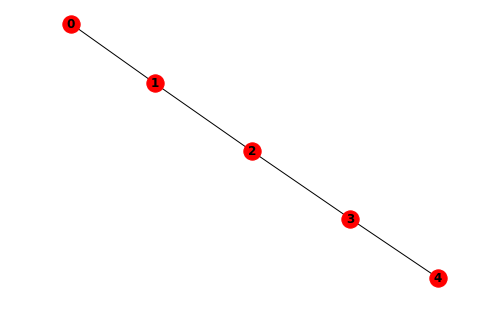

In [14]:
# Nearest neighbour
nnenv = gym.make('quantcircuit-v0')
nnenv.var_init(5,connectivity='nearest_neighbour')
nnenv.plot_connectivity_graph()

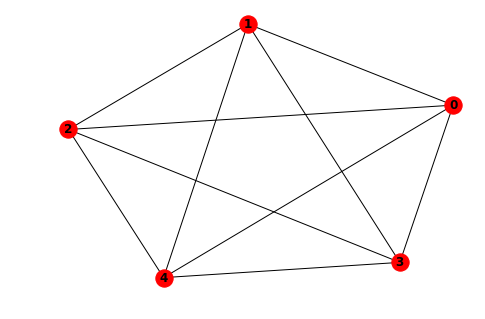

In [15]:
# Fully Connected
fc_env = gym.make('quantcircuit-v0')
fc_env.var_init(5,connectivity='fully_connected')
fc_env.plot_connectivity_graph()

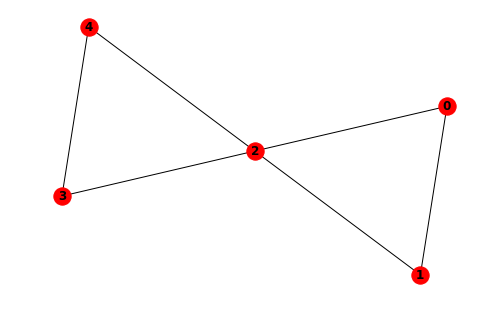

In [16]:
# IBM - limited to 5, 14 or 20 qubits (these are the only current physical architectures)
ibm_env = gym.make('quantcircuit-v0')
ibm_env.var_init(5,connectivity='ibm')
ibm_env.plot_connectivity_graph()

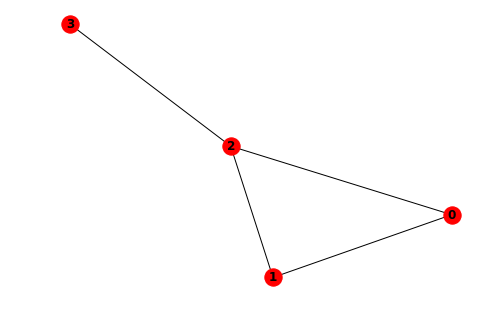

In [17]:
# Custom
custom_conn = np.array([[1,1,1,0],[1,1,1,0],[1,1,1,1],[0,0,1,1]])
custom_env = gym.make('quantcircuit-v0')
custom_env.var_init(4,connectivity='custom',custom_connectivity=custom_conn)
custom_env.plot_connectivity_graph()

#### Generating goal curriculums
An added feature of the environment is the ability to generate a curriculum of goals, that starts out with relatively 'easy' goal state or unitaries and gets progressively harder. 

In [26]:
num_gates = 2
curriculum, tracker = env.make_curriculum(num_gates)

Curriculum contains the goals generated using only single gates, and combinations of two different gates while tracker contains the number of each type of goal.

In [27]:
curriculum

[[(1+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j],
 [(0.7071+0j), (0.7071+0j), 0j, 0j, 0j, 0j, 0j, 0j],
 [(0.7071+0j), 0j, (0.7071+0j), 0j, 0j, 0j, 0j, 0j],
 [(0.7071+0j), 0j, 0j, 0j, (0.7071+0j), 0j, 0j, 0j],
 [0j, (1+0j), 0j, 0j, 0j, 0j, 0j, 0j],
 [0j, 0j, (1+0j), 0j, 0j, 0j, 0j, 0j],
 [0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j],
 [(0.5+0j), (0.5+0j), (0.5+0j), (0.5+0j), 0j, 0j, 0j, 0j],
 [(0.5+0j), (0.5+0j), 0j, 0j, (0.5+0j), (0.5+0j), 0j, 0j],
 [0j, 0j, (0.7071+0j), (0.7071+0j), 0j, 0j, 0j, 0j],
 [0j, 0j, 0j, 0j, (0.7071+0j), (0.7071+0j), 0j, 0j],
 [(0.7071+0j), (-0.7071+0j), 0j, 0j, 0j, 0j, 0j, 0j],
 [(0.7071+0j), 0j, 0j, (0.7071+0j), 0j, 0j, 0j, 0j],
 [(0.7071+0j), 0j, 0j, 0j, 0j, (0.7071+0j), 0j, 0j],
 [(0.5+0j), 0j, (0.5+0j), 0j, (0.5+0j), 0j, (0.5+0j), 0j],
 [0j, (0.7071+0j), 0j, (0.7071+0j), 0j, 0j, 0j, 0j],
 [0j, 0j, 0j, 0j, (0.7071+0j), 0j, (0.7071+0j), 0j],
 [(0.7071+0j), 0j, (-0.7071+0j), 0j, 0j, 0j, 0j, 0j],
 [(0.7071+0j), 0j, 0j, 0j, 0j, 0j, (0.7071+0j), 0j],
 [0j, (0.7071+0j), 0j, 0j, 0j

In [28]:
tracker

[7, 18]